# Customer Segmentation

## Introduction


### Problem
We are given 10 features for customers and we must divide customers into segments.

### Installing libraries

In [231]:
!pip3 install kneed
!pip install git+https://github.com/sevamoo/SOMPY

  Cloning https://github.com/sevamoo/SOMPY to /tmp/pip-req-build-ibjhyb1_
  Created wheel for SOMPY: filename=SOMPY-1.1.1-py3-none-any.whl size=28154 sha256=4c316dbb345d361a6bfa5fa4f2191b033269e51bc808db7f3a88e3ed78118e48
  Stored in directory: /tmp/pip-ephem-wheel-cache-spjug44d/wheels/1b/5e/df/033e339ae54ce5ebb44a2d680b3c1d996010bc06e13f2ccf4a
Successfully built SOMPY


## Importing libraries
Load all the necessary dependencies which will be required for the purpose of analysis.

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from statistics import mode
import os as os
from warnings import filterwarnings
filterwarnings('ignore')
from scipy.io import loadmat
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import math
import glob
import urllib3
import joblib
import random
from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import matplotlib
import logging
%matplotlib inline
sb.set_style('darkgrid')

## Getting to know general outline of given data


In [233]:
path1 = os.getcwd() + '/data/archive/Test.csv'
path = os.getcwd() + '/data/archive/Train.csv'
test_df = pd.read_csv(path1)
df = pd.read_csv(path)
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [234]:
test_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


It is clear that for our goal we will not need two variables: ID and Segmentation, so we can just remove them

In [235]:
df.drop('ID', axis=1, inplace=True)
df.drop('Segmentation', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [236]:
df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


now let's look at the bigger picture

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 567.4+ KB


### as we can see, there are null values in our data so we will have to treat them

## helper functions for null value treatment

In [238]:
def get_null_columns(df):
    null_cols = df.isna().sum().sort_values(ascending=False)
    null_cols = null_cols[null_cols > 0]
    if len(null_cols):
        plt.title('Null value count before imputation')
        sb.barplot(null_cols.values,null_cols.index)
        return null_cols
    else:
        return None
    
def get_num_cols(df):
    return df.select_dtypes(include="number").columns.values

def get_cat_cols(df):
    return df.select_dtypes(exclude="number").columns.values

def treat_null_cols(df):
    nulls = get_null_columns(df)
    print(nulls)
    if nulls is not None:
        null_columns = nulls.index.values.tolist()
        for col in null_columns:
            # Categorical columns
            if df[col].dtype == 'object':
                df.loc[:,col]=df.loc[:,col].fillna(method='ffill')
                df.loc[:,col]=df.loc[:,col].fillna(method='bfill')
            # Numerical columns    
            elif col in ("Work_Experience","Family_Size"):
                #Discrete features
                df[col].fillna(df[col].mode()[0],inplace=True)
            else:
                #Continuous features
                df[col].fillna(df[col].median(),inplace=True)
        print("Columns after imputation".center(38,'='))
        df.info()
    else:
        print('No null values !')

## Imputing data

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
dtype: int64
=======Columns after imputation=======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     8068 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        8068 non-null   object 
 4   Profession       8068 non-null   object 
 5   Work_Experience  8068 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      8068 non-null   float64
 8   Var_1            8068 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 567.4+ KB
Work_Experience    269
Family_Size        113
Ever_Married        50
Profession          38
Var_1               32
Graduated          

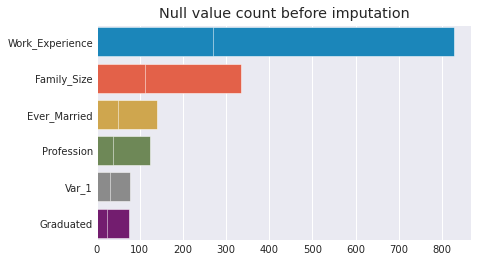

In [239]:
treat_null_cols(df)
treat_null_cols(test_df);

## EDA (Exploratory Data Analysis)

## Univariate Analysis

### Numerical features

### Age

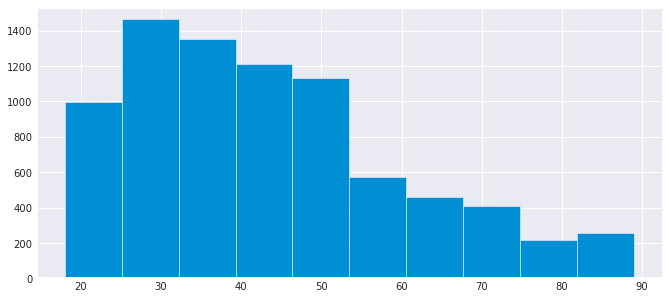

In [240]:
df['Age'].hist(figsize=(10, 5));

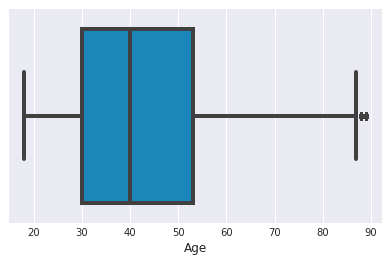

In [241]:
sb.boxplot(x='Age', data=df);

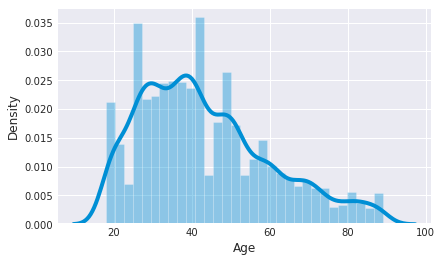

In [242]:
sb.distplot(df['Age']);

we can see that customers are mostly distributed from 26-52 years and distribution is right skewed

### Work Experience

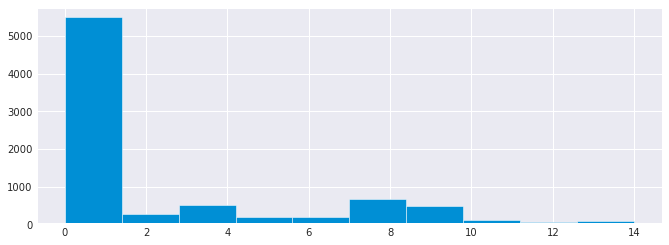

In [243]:
df['Work_Experience'].hist(figsize=(10, 4));

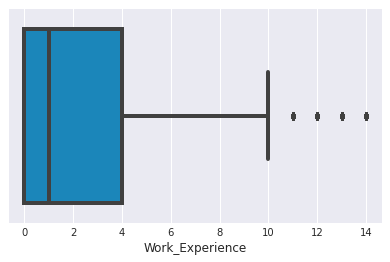

In [244]:
sb.boxplot(x='Work_Experience', data=df);

we can see that total majority of customers have low, 0-1 years of work experience

### Family Size

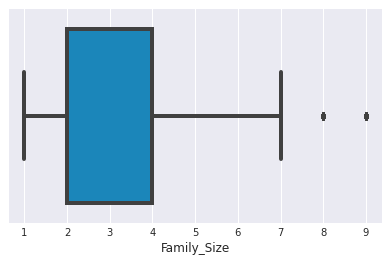

In [245]:
sb.boxplot(x='Family_Size', data=df);


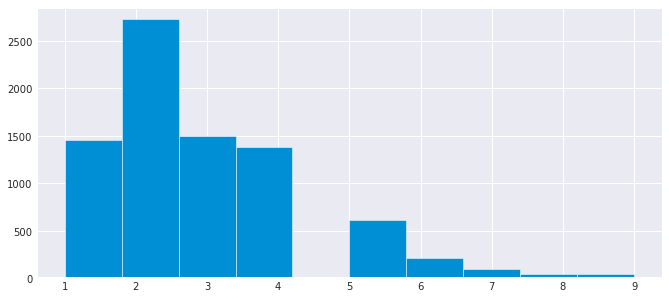

In [246]:
df['Family_Size'].hist(figsize=(10, 5));

from these plots can be inferred that majority of customers have family size of 2-4 members

#### Let us check whether this non uniformity in work experience is due to the difference in education level

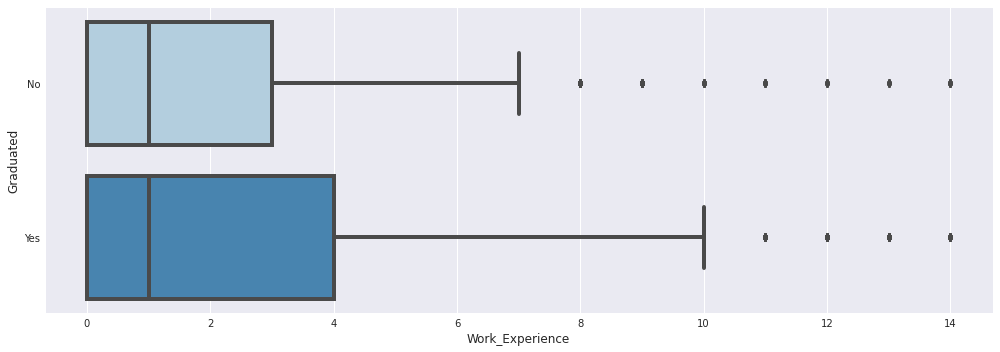

In [247]:
plt.figure(figsize=(14,5))
ax = sb.boxplot(data=df,x="Work_Experience",y="Graduated",palette='Blues')
fig = plt.gcf()
plt.tight_layout()

It can be observed that variation in Work Experience is more among individuals who are Graduates but surprisingly they have the same median

### Categorical Features

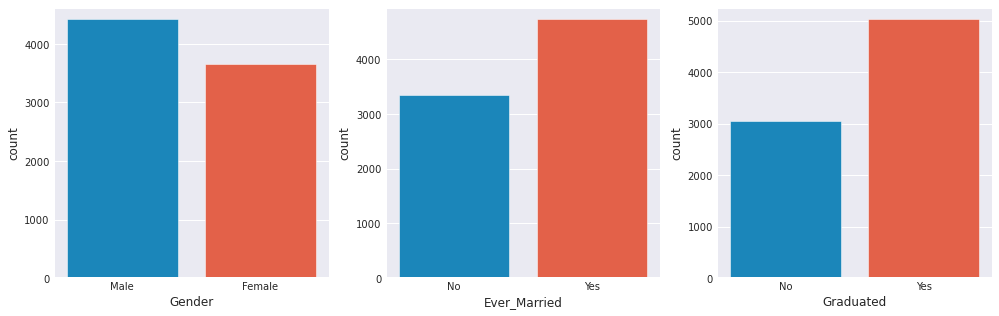

In [248]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sb.countplot(x='Gender', data=df, ax=axes[0]);
sb.countplot(x='Ever_Married', data=df, ax=axes[1]);
sb.countplot(x='Graduated', data=df, ax=axes[2]);

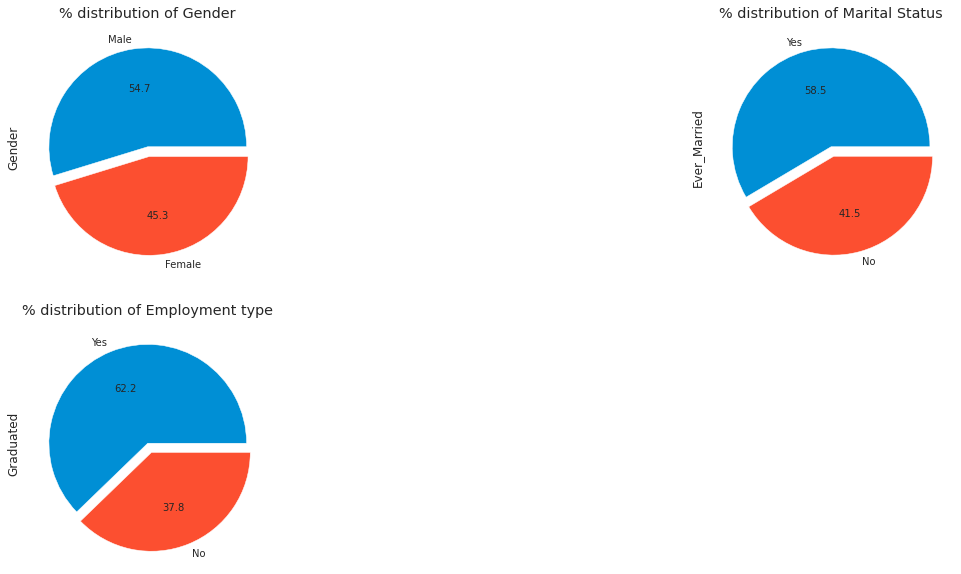

In [249]:
plt.figure(1)
plt.subplot(221)
df['Gender'].value_counts().plot.pie(title='% distribution of Gender',figsize=(20,10),autopct="%1.1f",explode=[0,.1])

plt.subplot(222)
df['Ever_Married'].value_counts().plot.pie(title='% distribution of Marital Status',autopct="%1.1f",explode=[0,.1])

plt.subplot(223)
df['Graduated'].value_counts().plot.pie(title='% distribution of Employment type',autopct="%1.1f",explode=[0,.1]);

we can see that most of the customers are graduated or not married. Also males are more then females by almost 10%

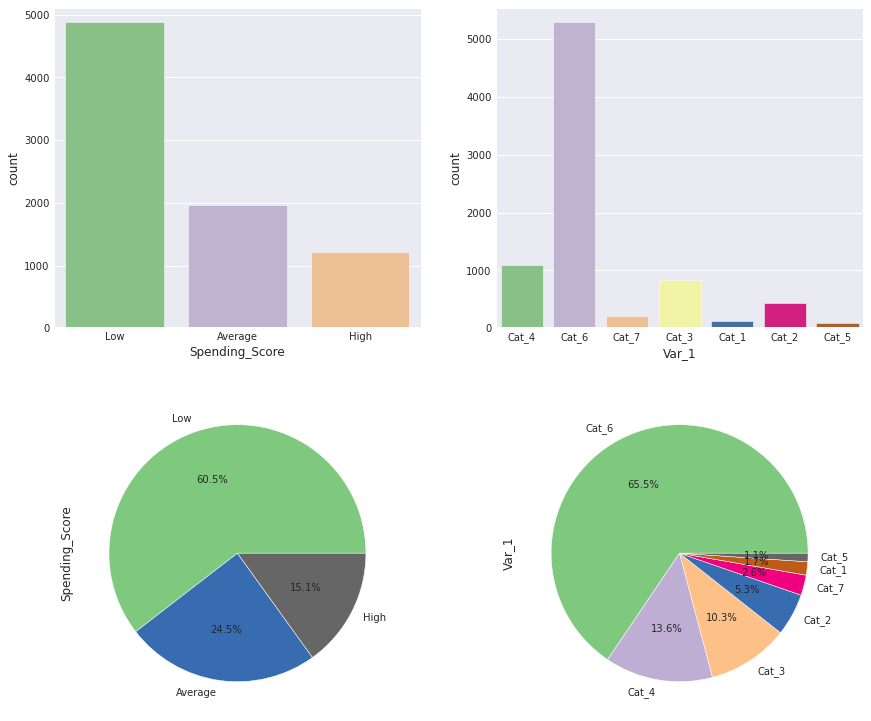

In [250]:
plt.figure(figsize=(20, 13))
plt.subplot(231)
sb.countplot(df['Spending_Score'],palette="Accent")
plt.subplot(234)
df['Spending_Score'].value_counts().plot.pie(cmap="Accent",autopct="%1.1f%%")


plt.subplot(232)
sb.countplot(df['Var_1'],palette="Accent")
plt.subplot(235)
df['Var_1'].value_counts().plot.pie(cmap="Accent",autopct="%1.1f%%")
plt.show()

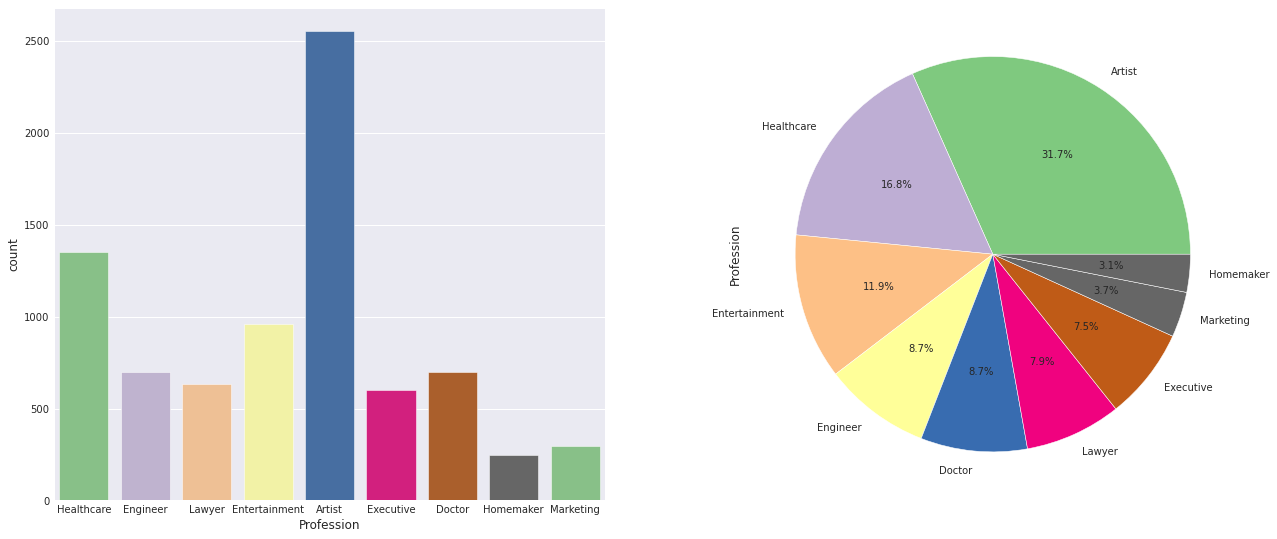

In [251]:
plt.figure(figsize=(30, 20))
plt.subplot(235)
sb.countplot(df['Profession'],palette="Accent")
plt.subplot(236)
df['Profession'].value_counts().plot.pie(cmap="Accent",autopct="%1.1f%%");

from above charts we can infer that:

1) there are wide range of professions among customers, but most widespread profession is artist(31.7%)

2) more that half of the customers have low spending score and with other data we can probably infer that most of the customers have low income

3) high majority of customers have Var_1 of Cat_6. This feature is anonymized so we do not know what that means. but from what I can see, my guess would be that it is income. for example Cat_7 would be 0-600, Cat_6 would be 600-1200, Cat_5 would be 1200-1800 and so on. It is just a guess though.

## Multivariate Analysis

#### Spending Score and Graduated

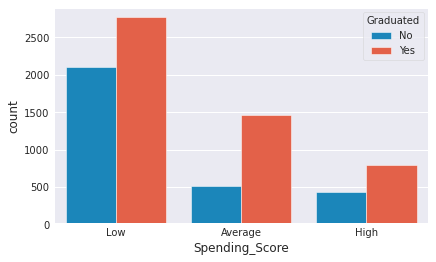

In [252]:
sb.countplot(x='Spending_Score', hue='Graduated', data=df);

surprisingly, in low spending score category there are more graduated people than ungraduated

#### Spending Score and Profession

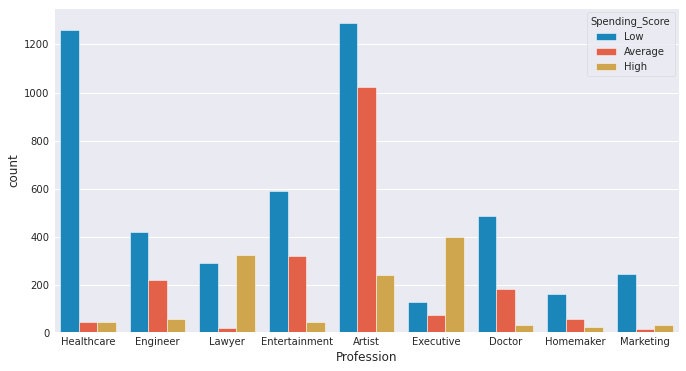

In [253]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Profession', hue='Spending_Score', data=df);

from this plot it is clear that customers from healthcare spend very little and they probably have low income. Also as expected executives have most chance of spending high amounts.

#### Spending Score and Var_1

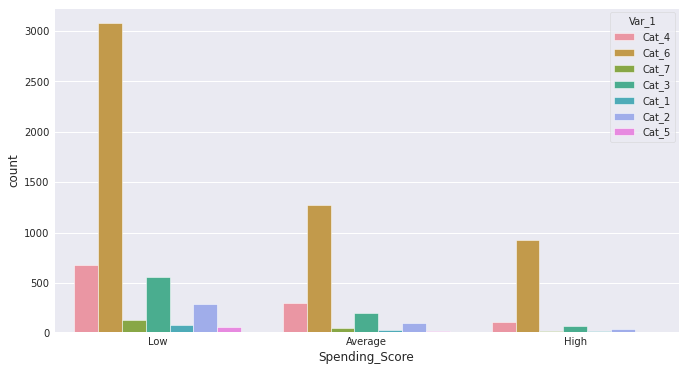

In [254]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Spending_Score', hue='Var_1', data=df);

from this graph my above theory is debunked. because high majority high spenders have Cat_6, so Var_1 cannot be income variable. Also, it is interesting that Var_1 distributions in each spending_score class are almost same

In [255]:
df.groupby(['Profession'])['Age'].agg([np.mean]).sort_values(by='mean', ascending=True).T

Profession,Healthcare,Marketing,Doctor,Homemaker,Engineer,Entertainment,Artist,Executive,Lawyer
mean,27.038433,37.006689,37.311522,38.244,41.762784,43.056075,46.189432,51.089256,74.630503


averagely youngest profession is healthcare and from above plot we know that they also had lowest spending score. also executives have highest chance of spending high amounts and they are one of the oldest group by age. so age and spending score might be related. let's check.

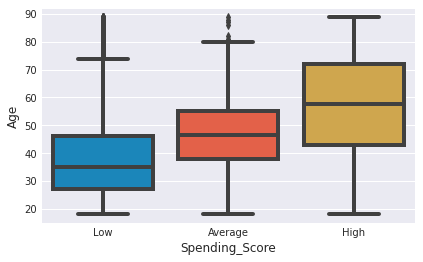

In [256]:
sb.boxplot(x = "Spending_Score", y = "Age", data = df);

as expected spending score increases with age

In [257]:
df.groupby(['Var_1'])['Age'].agg([np.mean]).sort_values(by='mean', ascending=True).T

Var_1,Cat_5,Cat_2,Cat_7,Cat_4,Cat_3,Cat_1,Cat_6
mean,37.593023,37.795349,38.718447,39.151322,39.234583,39.881481,45.857764


It is quite interesting that ages are fairly equally distributed between categories of Var_1

Also, I looked at many relation tables between Var_1 and other features, but still couldn't figure out any logical information on Var_1 

### Creating new features

#### Profession Type

I had two ideas of dividing professions by types. First one was dividing humanitarian and technician professions, but it had problem of humanitarians being high majority, 70% or something like that. So I went with the second idea of dividing professions in categories of content creator and content manager, because they are almost even in numbers. Content creators would be people whose job is to create something new which is appreciated by public. And content creators would be people whose job is to manage/order/organize already created stuff. They don't need to create something new, they should make best use of what already is.

In [258]:
def get_profession_type(x):
    if x == 'Artist' or x == 'Engineer' or x == 'Entertainment' or x == 'Marketing':
        return 'Content_Creator'
    return 'Content_Manager'

In [259]:
df['Profession_Type'] = df['Profession'].apply(get_profession_type)
test_df['Profession_Type'] = test_df['Profession'].apply(get_profession_type)
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Profession_Type
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,Content_Manager
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,Content_Creator
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,Content_Creator
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,Content_Manager
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,Content_Creator


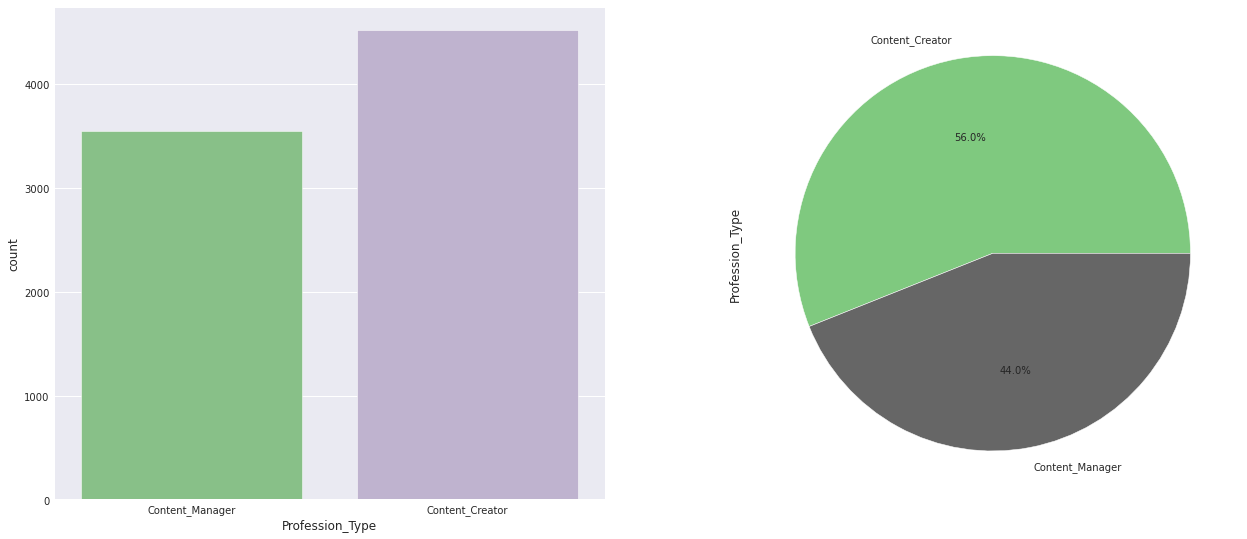

In [260]:
plt.figure(figsize=(30, 20))
plt.subplot(234)
sb.countplot(df['Profession_Type'],palette="Accent")
plt.subplot(235)
df['Profession_Type'].value_counts().plot.pie(cmap="Accent",autopct="%1.1f%%");

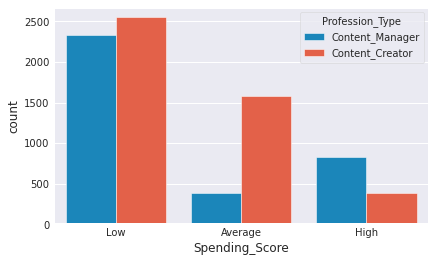

In [261]:
sb.countplot(x='Spending_Score', hue='Profession_Type', data=df);

while both types of professions spending score floor is almost same, Content_Manager's spending score ceiling is higher. it seems you are either high spender as Content_Manager or low spender, with almost zero middle ground. while Content_Creators seem to cap at average spending.

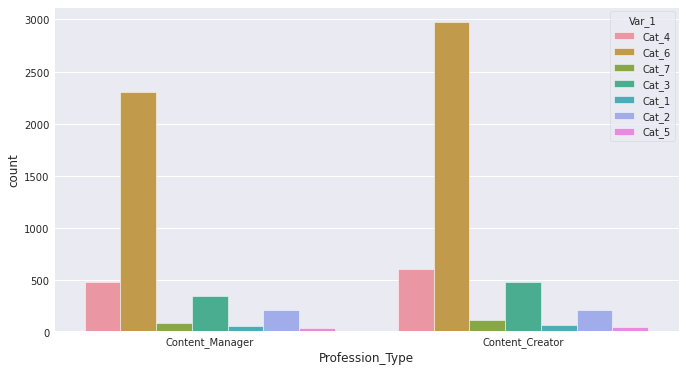

In [262]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Profession_Type', hue='Var_1', data=df);

I couldn't determine anything new on Var_1 from this graph.

#### Work Experience Category

In [263]:
def get_experience_category(x):
    if x <= 5:
        return 'Low'
    if x < 10:
        return 'Average'
    return 'High'

In [264]:
df['Experience_Category'] = df['Work_Experience'].apply(get_experience_category)
test_df['Experience_Category'] = test_df['Work_Experience'].apply(get_experience_category)
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Profession_Type,Experience_Category
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,Content_Manager,Low
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,Content_Creator,Low
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,Content_Creator,Low
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,Content_Manager,Low
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,Content_Creator,Low


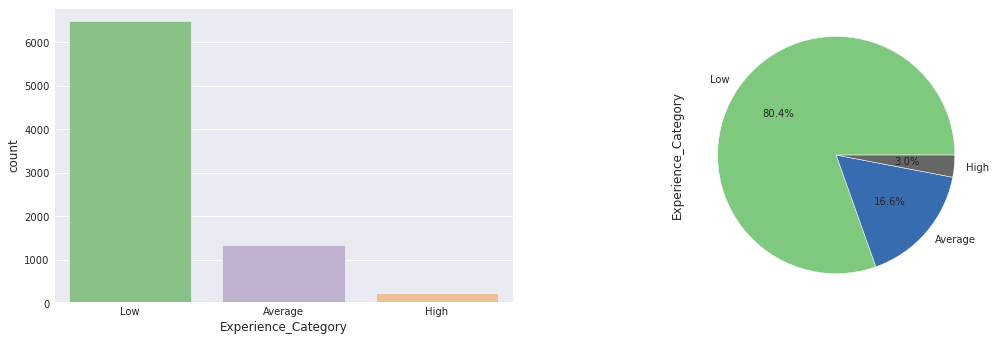

In [265]:
plt.figure(figsize=(25, 12))
plt.subplot(234)
sb.countplot(df['Experience_Category'],palette="Accent")
plt.subplot(235)
df['Experience_Category'].value_counts().plot.pie(cmap="Accent",autopct="%1.1f%%");

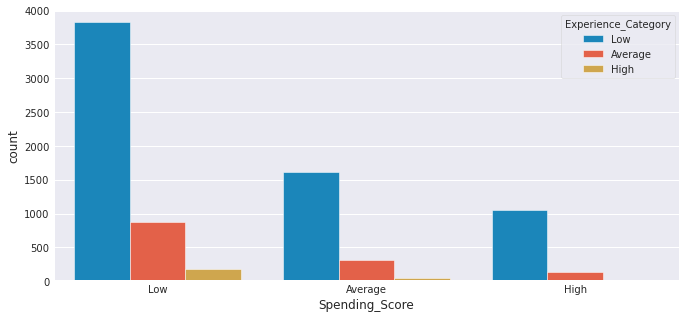

In [266]:
plt.figure(figsize=(10, 5))
sb.countplot(x='Spending_Score', hue='Experience_Category', data=df);

It was quite surprising that spending score distribution doesn't depend on experience category. I thought that higher experience => higher income => higher spending score, but it seems I was wrong. 

let's check once again if we can get any info on Var_1 from this

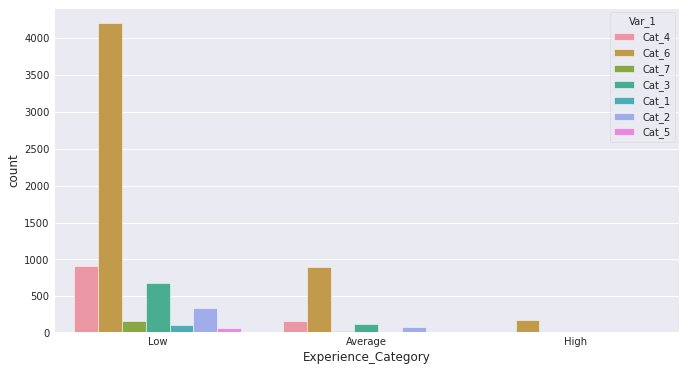

In [267]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Experience_Category', hue='Var_1', data=df);

Finally! some information about Var_1 with some meaning behind it. We can see that in low and average Experience Category var_1 distributionsare relatively same BUT in high experience category we can see that it's almost all Cat_6 with very little of Cat_4, other categories are prety much nonexistent. 

But this might be false and we just can't see Var_1 distribution in high experience_category on the graph because of smallness of that category. let's check that.

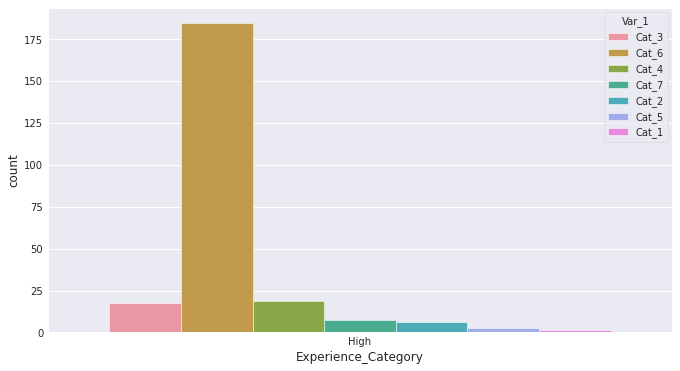

In [268]:
is_experienced = df['Experience_Category'] == 'High'
experienced_df = df[is_experienced]
plt.figure(figsize=(10, 6))
sb.countplot(x='Experience_Category', hue='Var_1', data=experienced_df);
experienced_df = experienced_df[0:0] # we won't need this dataframe anymore

It seems my enthusiasm was misplaced, we can't really make any real assumptions based on this data. First of all, it is too small and second distribution isn't as different as I thougth at first.

## Data Preparation

### Encoding Categorical Variables

In [269]:
df_saved = df.copy()
test_df_saved = test_df.copy()

# Gender
d = {'Male':1,'Female':0}
df['Gender'].replace(d, inplace=True)
test_df['Gender'].replace(d, inplace=True)

# Ever_Married
d = {'Yes':1,'No':0}
df['Ever_Married'].replace(d, inplace=True)
test_df['Ever_Married'].replace(d, inplace=True)


# Graduated
d ={'Yes':1, 'No':0}
df['Graduated'].replace(d, inplace=True)
test_df['Graduated'].replace(d, inplace=True)


# Profession_Type
d ={'Content_Manager':1, 'Content_Creator':0}
df['Profession_Type'].replace(d, inplace=True)
test_df['Profession_Type'].replace(d, inplace=True)


# Spending_Score
d ={'High':2, 'Average':1, 'Low':0}
df['Spending_Score'].replace(d, inplace=True)
test_df['Spending_Score'].replace(d, inplace=True)


# Experience_Category
d ={'High':2, 'Average':1, 'Low':0}
df['Experience_Category'].replace(d, inplace=True)
test_df['Experience_Category'].replace(d, inplace=True)


# # Profession
# d = {'Healthcare':8, 'Engineer':7, 'Lawyer':6, 'Entertainment':5,
#      'Artist':4, 'Executive':3, 'Doctor':2, 'Homemaker':1, 'Marketing':0}
# df['Profession'].replace(d, inplace=True)
# # Var_1
# d ={'Cat_7':6, 'Cat_6':5, 'Cat_5':4, 'Cat_4':3, 'Cat_3':2, 'Cat_2':1, 'Cat_1':0}
# df['Var_1'].replace(d, inplace=True)

for others we can't just transofrm them into numbers, because for example if we assign 0 to homemaker, 1 to healthcare and 2 to entertainment model will think that homemaker is closer to healthcare than entertainment.

so, let's do one-hot encoding that will add columns for each profession with binary values of 0 and 1, meaning that if this person has 1 in doctor column then he/she is a doctor and will have zeroes in other profession columns

In [270]:
# converting nominal variables into dummy variables
pf = pd.get_dummies(df.Profession,prefix='Profession')
df = pd.concat([df,pf],axis=1)

test_pf = pd.get_dummies(test_df.Profession,prefix='Profession')
test_df = pd.concat([test_df,test_pf],axis=1)

vr = pd.get_dummies(df.Var_1,prefix='Var_1')
df = pd.concat([df,vr],axis=1)

test_vr = pd.get_dummies(test_df.Var_1,prefix='Var_1')
test_df = pd.concat([test_df,test_vr],axis=1)



In [271]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Profession_Type,...,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,1,0,22,0,Healthcare,1.0,0,4.0,Cat_4,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,38,1,Engineer,1.0,1,3.0,Cat_4,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,67,1,Engineer,1.0,0,1.0,Cat_6,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,67,1,Lawyer,0.0,2,2.0,Cat_6,1,...,0,1,0,0,0,0,0,0,1,0
4,0,1,40,1,Entertainment,1.0,2,6.0,Cat_6,0,...,0,0,0,0,0,0,0,0,1,0


### Reducing Skewness

#### Age

0.696020586305935


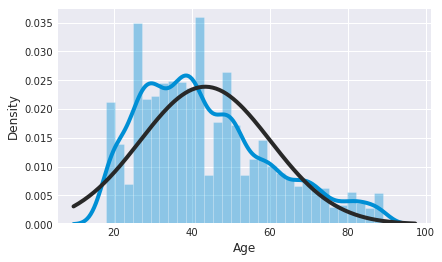

In [272]:
#old skewness
col_name = 'Age'
print(df[col_name].skew())
ax = sb.distplot(df[col_name],fit=stats.norm)

applying log function gives best results(I tried sqrt, cbrt and log). I will try these three on others and will choose whatever gives best result.

-0.05243989561012818


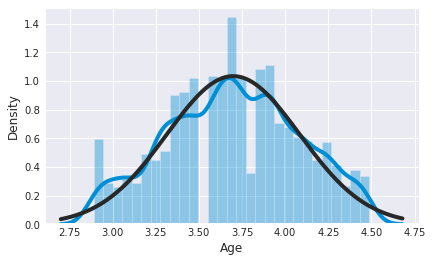

In [273]:
#new skewness
col_name = 'Age'
df[col_name] = np.log(df[col_name])
test_df[col_name] = np.log(test_df[col_name])
print(df[col_name].skew())
ax = sb.distplot(df[col_name],fit=stats.norm)

1.4731291640065542


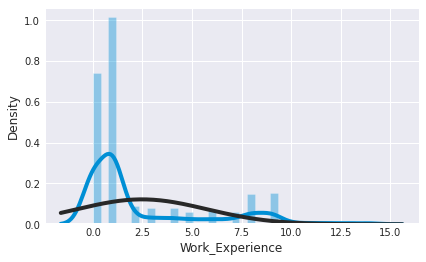

In [274]:
#old skewness
col_name = 'Work_Experience'
print(df[col_name].skew())
ax = sb.distplot(df[col_name],fit=stats.norm)

0.002303042895532347


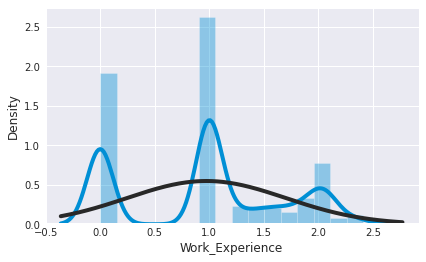

In [275]:
#new skewness
col_name = 'Work_Experience'
df[col_name] = np.cbrt(df[col_name])
test_df[col_name] = np.cbrt(test_df[col_name])
print(df[col_name].skew())
ax = sb.distplot(df[col_name],fit=stats.norm)

1.075736600746189


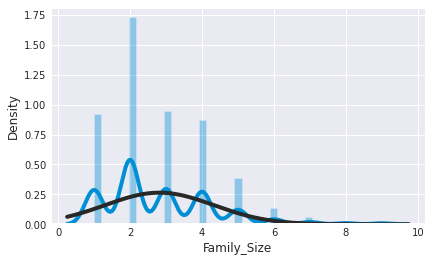

In [276]:
#old skewness
col_name = 'Family_Size'
print(df[col_name].skew())
ax = sb.distplot(df[col_name],fit=stats.norm)

-0.15193377197321453


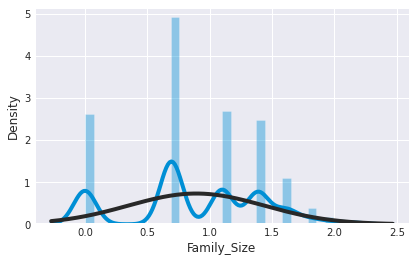

In [277]:
#new skewness
 
col_name = 'Family_Size'
df[col_name] = np.log(df[col_name])
test_df[col_name] = np.log(test_df[col_name])
print(df[col_name].skew())
ax = sb.distplot(df[col_name],fit=stats.norm)

Now lets look at the correlation between all the numerical variables. We will use the heat map to visualize the correlation.

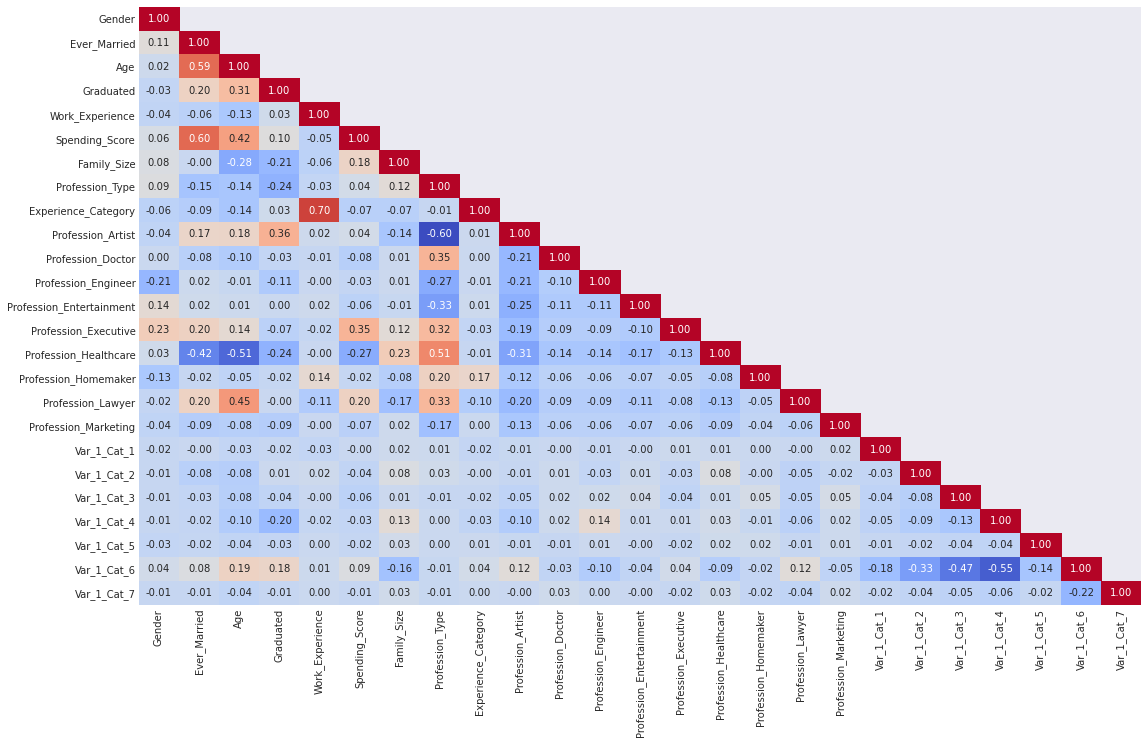

In [278]:
matrix = df.corr()
f, ax = plt.subplots(figsize=(16, 11))
with sb.axes_style("white"):
    sb.heatmap(matrix,mask=np.triu(matrix,1),annot=True,fmt=".2f", vmax=.8,cbar=False,cmap="coolwarm");

from this table we can conclude following things:

1) older people have more chance to be married/married people are older compared to unmarried

2) married people spend way more than unmarried

3) lawyers have average age way higher than other professions

4) as I said older people tend to be married and so they also tend to spend more

5) executives tend to spend more

6) graduated people tend to be content creators little bit more than managers.

Also, one interesting thing is that Var_1 isn't really correlated to any other features.

### Normalization

let's scale continuous variables to be in 0,1 range

In [279]:
encoded_df = df.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Age','Work_Experience','Family_Size']] = scaler.fit_transform(df[['Age','Work_Experience','Family_Size']])
test_df[['Age','Work_Experience','Family_Size']] = scaler.fit_transform(test_df[['Age','Work_Experience','Family_Size']])

#### Dropping of Var_1

I was really intereseted and I really tried to get any logical info on Var_1, but unfortunately I couldn't find any meaning behind it. I looked at it's relations to many other features but nothing gave me hint of anything meaningful. Some of the experiments are in the notebook, some aren't because they were too many and including all of them would just pollute this notebook. After all I have to drop Var_1 columns, because it won't help me in analysis. 

In [280]:
df.drop(['Var_1','Var_1_Cat_1','Var_1_Cat_2','Var_1_Cat_3','Var_1_Cat_4','Var_1_Cat_5','Var_1_Cat_6','Var_1_Cat_7'], axis = 1, inplace = True) 
test_df.drop(['Var_1','Var_1_Cat_1','Var_1_Cat_2','Var_1_Cat_3','Var_1_Cat_4','Var_1_Cat_5','Var_1_Cat_6','Var_1_Cat_7'], axis = 1, inplace = True) 
encoded_df.drop(['Var_1','Var_1_Cat_1','Var_1_Cat_2','Var_1_Cat_3','Var_1_Cat_4','Var_1_Cat_5','Var_1_Cat_6','Var_1_Cat_7'], axis = 1, inplace = True) 
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Profession_Type,Experience_Category,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,1,0,0.125555,0,Healthcare,0.414913,0,0.630930,1,0,0,0,0,0,0,1,0,0,0
1,0,1,0.467516,1,Engineer,0.414913,1,0.500000,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0.822342,1,Engineer,0.414913,0,0.000000,0,0,0,0,1,0,0,0,0,0,0
3,1,1,0.822342,1,Lawyer,0.000000,2,0.315465,1,0,0,0,0,0,0,0,0,1,0
4,0,1,0.499609,1,Entertainment,0.414913,2,0.815465,0,0,0,0,0,1,0,0,0,0,0


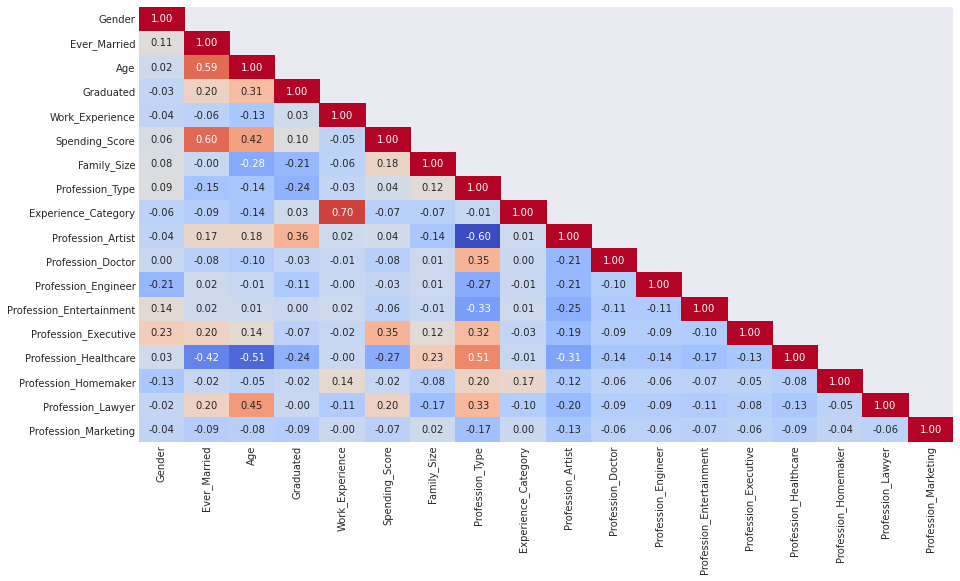

In [281]:
matrix = df.corr()
f, ax = plt.subplots(figsize=(13, 8))
with sb.axes_style("white"):
    sb.heatmap(matrix,mask=np.triu(matrix,1),annot=True,fmt=".2f", vmax=.8,cbar=False,cmap="coolwarm");

Just for clearer view of correlations after dropping Var_1

# Clustering

### Choosing clustering and reporting variables

company that we are clustering customers for is an automobile company and has five products. For choosing right clustering policy we should think about what types of segments could possibly be in relation to automobile products. 

1) First of all, products probably have different prices, so we should include variables that give us information about how much clients can afford. 

2) Second, cars have different purposes, for example some are family cars and married people with higher family size might tend to buy cars like that. 

3) Third, younger and older people have different tastes in cars, for example, younger people like sport cars more.

4) And Finally, men and women might have different tastes too.

we can make clusters with this logics and then maybe offer each segment advetisement suited to them if possible.

to offer better example, imagine if this company was Audi and it had 5 products: A3, A4, A5, A6, A7.

For example, audi would offer A3 to young people with low spending score. A5 to young people with average spending score. A4 to middle aged people with average spending score and no or little family. A6 to middle aged/old people with family because A6 is a family car. And A7 to middle aged people with high spending score. There could be A8 for executives because it is business class but I decided against including it because of nature of our data. My example didn't cover gender, but I think it explained the point.

In [282]:
clustering_vars = ['Age', 'Ever_Married', 'Spending_Score', 'Family_Size', 'Gender']
# everything other can be used as reporting variable
data = df[clustering_vars].copy()
test_data = test_df[clustering_vars].copy()
data.head()

,Age,Ever_Married,Spending_Score,Family_Size,Gender
0,0.125555,0,0,0.630930,1
1,0.467516,1,1,0.500000,0
2,0.822342,1,0,0.000000,0
3,0.822342,1,2,0.315465,1
4,0.499609,1,2,0.815465,0


## K-Means

### Manual implementation

#### Helper functions

In [283]:
# code that finds closest centroids to each point and so assigns clusters to points
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    import math
    for i in range(m):
        min_dist = math.inf
        for j in range(k):
            dist = np.sum(np.square(X[i]-centroids[j]))
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

In [284]:
# computes new centroids by finding new mass center
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [285]:
# initializes random centroids
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

In [286]:
#runs k-means algorithm once for given iteration count
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

In [287]:
#returns sum of all costs. cost is square of distance to centroid from point.
def compute_cost(X, centroids, idx):
    cost = 0
    m = X.shape[0]
    for i in range(m):
        cost += np.sum(np.square(X[i] - centroids[int(idx[i])]))
    return cost

In [288]:
#runs k-means algorithm multiple times and chooses best result. 
#centroids are randomed many times to prevent worse case scenarios
def get_clusters(X, cluster_num, k_mean_count, one_max_iters):
    import math
    best_cost = math.inf
    best_idx = None
    best_centroids = None
    for i in range(k_mean_count):
        initial_centroids = init_centroids(X, cluster_num)
        idx, centroids = run_k_means(X, initial_centroids, one_max_iters)
        curr_cost = compute_cost(X, centroids, idx)
        if curr_cost < best_cost:
            best_cost = curr_cost
            best_idx = idx
            best_centroids = centroids
    return best_cost, best_idx, best_centroids

#### forming clusters

for getting best clustering we should also determine how many clusters are best.
we will do that with eblow method.
we will try to have different amounts of clusters and then decide what amount is best by comparing costs.

In [289]:
costs = []
new_data = np.matrix(df[clustering_vars])
for k in range(1, 11):
    cost, idx, centroids = get_clusters(new_data, k, 5, 10)
    costs.append(cost)

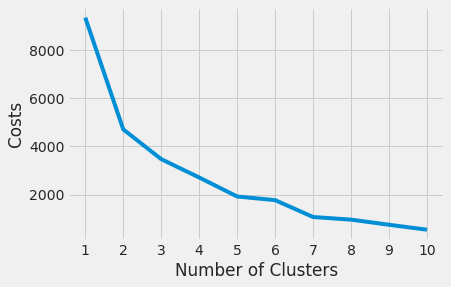

Cluster Number:  0 | Cost:  9356 | Cost Change:  9356
Cluster Number:  1 | Cost:  4709 | Cost Change:  -4646
Cluster Number:  2 | Cost:  3471 | Cost Change:  -1237
Cluster Number:  3 | Cost:  2709 | Cost Change:  -762
Cluster Number:  4 | Cost:  1918 | Cost Change:  -791
Cluster Number:  5 | Cost:  1767 | Cost Change:  -150
Cluster Number:  6 | Cost:  1065 | Cost Change:  -701
Cluster Number:  7 | Cost:  956 | Cost Change:  -109
Cluster Number:  8 | Cost:  743 | Cost Change:  -213
Cluster Number:  9 | Cost:  538 | Cost Change:  -205


In [290]:
#costs = [9356.25937064053, 4709.358905725829, 3471.782927694993, 2709.4176571860894, 1918.3257079488994, 1767.378150615976, 1065.6121633197681, 956.5215806945246, 743.4177776167705, 538.0947533698552]
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), costs)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Costs")
plt.show()

prevCost = 0
for i in range(len(costs)):
    print("Cluster Number: ", i, "| Cost: ", int(costs[i]), "| Cost Change: ", int(costs[i] - prevCost))
    prevCost = costs[i]

from this graph, in my opinion, optimal numer of clusters is 5. After that cost change isn't worth it.

### Library Implementation

#### Optimizing cluster count

In [291]:
# let's run K-Means 10 times with 1-11 clusters and check total costs.
# This will help us determine best number of clusters

costs = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    costs.append(kmeans.inertia_)

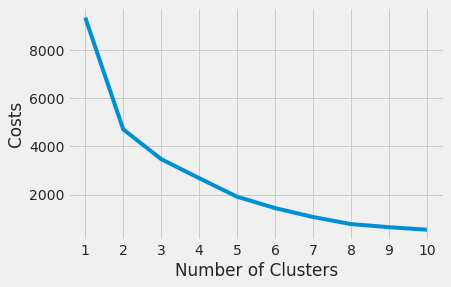

Cluster Number:  0 | Cost:  9356 | Cost Change:  9356
Cluster Number:  1 | Cost:  4709 | Cost Change:  -4646
Cluster Number:  2 | Cost:  3471 | Cost Change:  -1237
Cluster Number:  3 | Cost:  2680 | Cost Change:  -791
Cluster Number:  4 | Cost:  1908 | Cost Change:  -771
Cluster Number:  5 | Cost:  1435 | Cost Change:  -472
Cluster Number:  6 | Cost:  1065 | Cost Change:  -370
Cluster Number:  7 | Cost:  771 | Cost Change:  -293
Cluster Number:  8 | Cost:  641 | Cost Change:  -129
Cluster Number:  9 | Cost:  538 | Cost Change:  -103


In [292]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), costs)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Costs")
plt.show()

prevCost = 0
for i in range(len(costs)):
    print("Cluster Number: ", i, "| Cost: ", int(costs[i]), "| Cost Change: ", int(costs[i] - prevCost))
    prevCost = costs[i]

looking at the diagram, in my opinion, optimal cluster number would be 5, because angle breaks little bit on 5, while on 4 it goes smoothly.

let's verify it with kneelocator "Determining the elbow point in the SSE curve isn’t always straightforward. If you’re having trouble choosing the elbow point of the curve, then you could use a Python package, kneed, to identify the elbow point programmatically"

In [293]:
locator = KneeLocator(
     range(1, 11), costs, curve="convex", direction="decreasing")

In [294]:
locator.elbow

3

I guess it said 3 because there is a slight break in angle on 3 too and then it continues smoothly until 5. But I will still go with 5 because I like it more.

In [295]:
kmeans5 = KMeans(n_clusters=5)
kmeans5.fit(data)
data.head()

,Age,Ever_Married,Spending_Score,Family_Size,Gender
0,0.125555,0,0,0.630930,1
1,0.467516,1,1,0.500000,0
2,0.822342,1,0,0.000000,0
3,0.822342,1,2,0.315465,1
4,0.499609,1,2,0.815465,0


before we get to plotting let's check how many clusters are optimal with sillhouete coefficients method.

In [296]:
silhouette_coefficients = []

#silhouette coefficient method doesn't work on 1 cluster so we have to start from 2
#it counts silhouette coefficients for each number of clusters. higher the better.
for k in range(2, 11):
    kmeansS = KMeans(n_clusters=k)
    kmeansS.fit(data)
    score = silhouette_score(data, kmeansS.labels_)
    silhouette_coefficients.append(score)


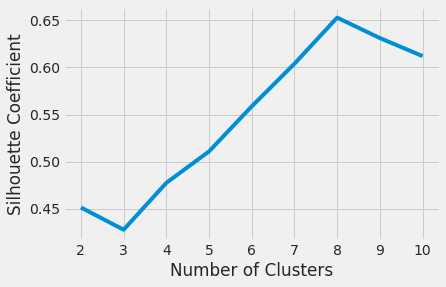

In [297]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

this method tells us that optimal number of clusters is 8, because silhouette coefficient is highest on 8.

### Using PCA for Plotting

let's reduce dimensions using PCA so we can plot our clusters

In [421]:
pca3D = PCA(n_components=3)
pca3D.fit(data)
data_3D = pca3D.transform(data)

pca2D = PCA(n_components=2)
pca2D.fit(data)
data_2D = pca2D.transform(data)


pca3D.fit(test_data)
test_data_3D = pca3D.transform(test_data)

pca2D.fit(test_data)
test_data_2D = pca2D.transform(test_data)

before we get to plotting clusters, let's look at how much data pca lost just for intereset, getting more familiar with using PCA and showing knowledge

#### PCA tradeoff graph

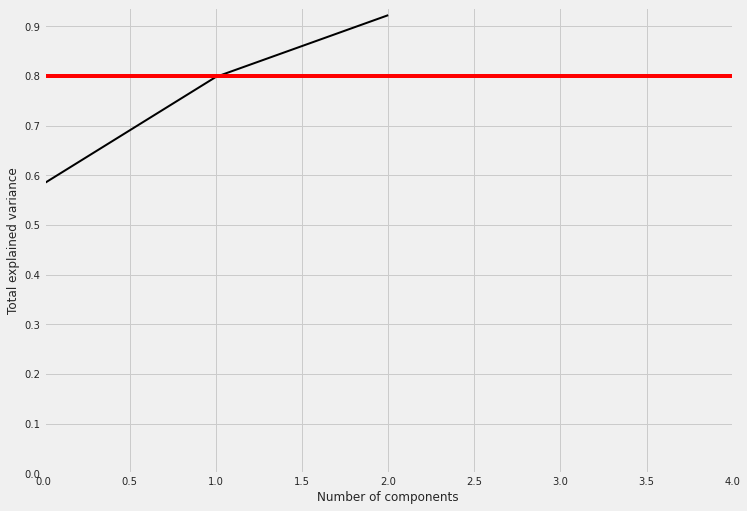

In [427]:
plt.figure(figsize=(11,8))
plt.plot(np.cumsum(pca3D.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 4)
plt.yticks(np.arange(0, 1.0, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.8, c='r')
plt.show();

### Plotting clusters

#### 2D

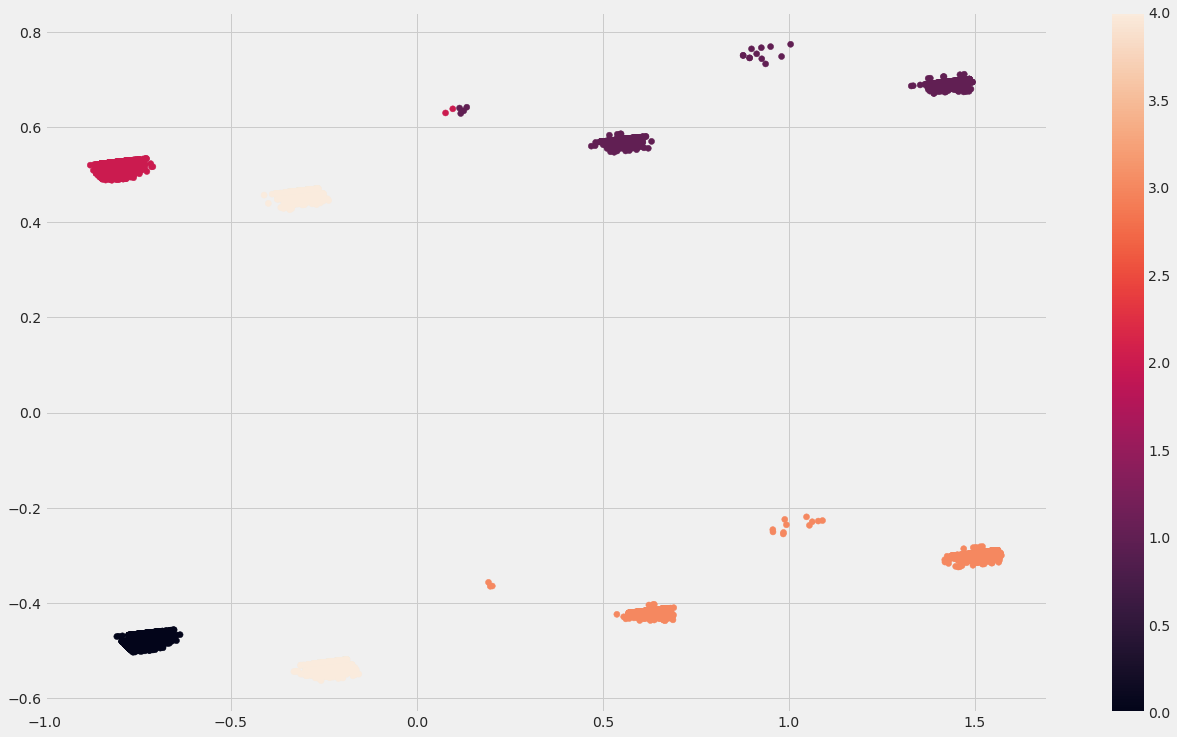

In [299]:
plt.figure(figsize=(20,12))
plt.scatter(data_2D[:,0], data_2D[:,1], c=kmeans5.labels_)
plt.colorbar();

#### 3D

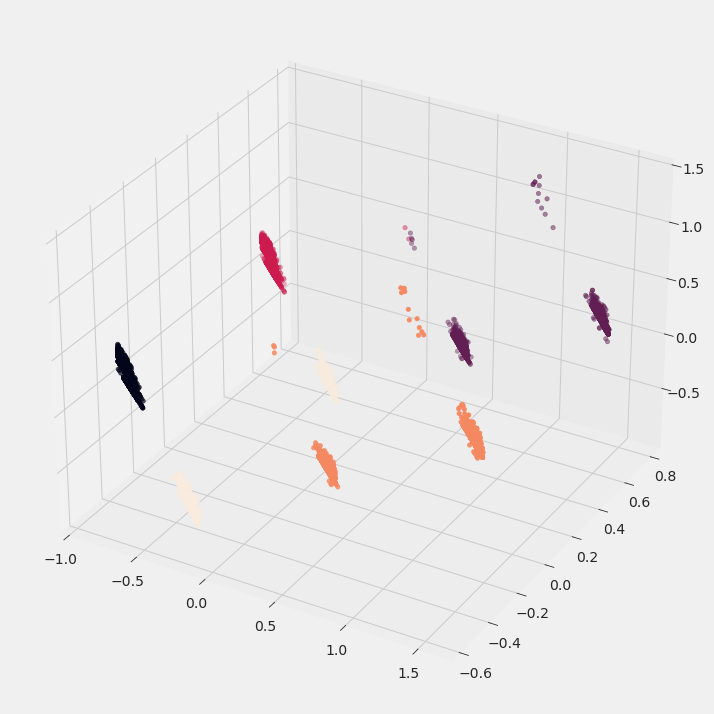

In [300]:
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection = '3d')
scatter = ax.scatter(data_3D[:,0], data_3D[:,1], data_3D[:,2], c=kmeans5.labels_)
plt.show()

we can see that there are 8 major clusters, so lets try dividing customers into 8 clusters and check if it will be good. Also silhouette coefficient method told us that 8 clusters are best way to divide our customers, so let's go with that.

In [301]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(data)
kmeans_test = KMeans(n_clusters=8)
kmeans_test.fit(test_data)
data.head()

,Age,Ever_Married,Spending_Score,Family_Size,Gender
0,0.125555,0,0,0.630930,1
1,0.467516,1,1,0.500000,0
2,0.822342,1,0,0.000000,0
3,0.822342,1,2,0.315465,1
4,0.499609,1,2,0.815465,0


#### 2D

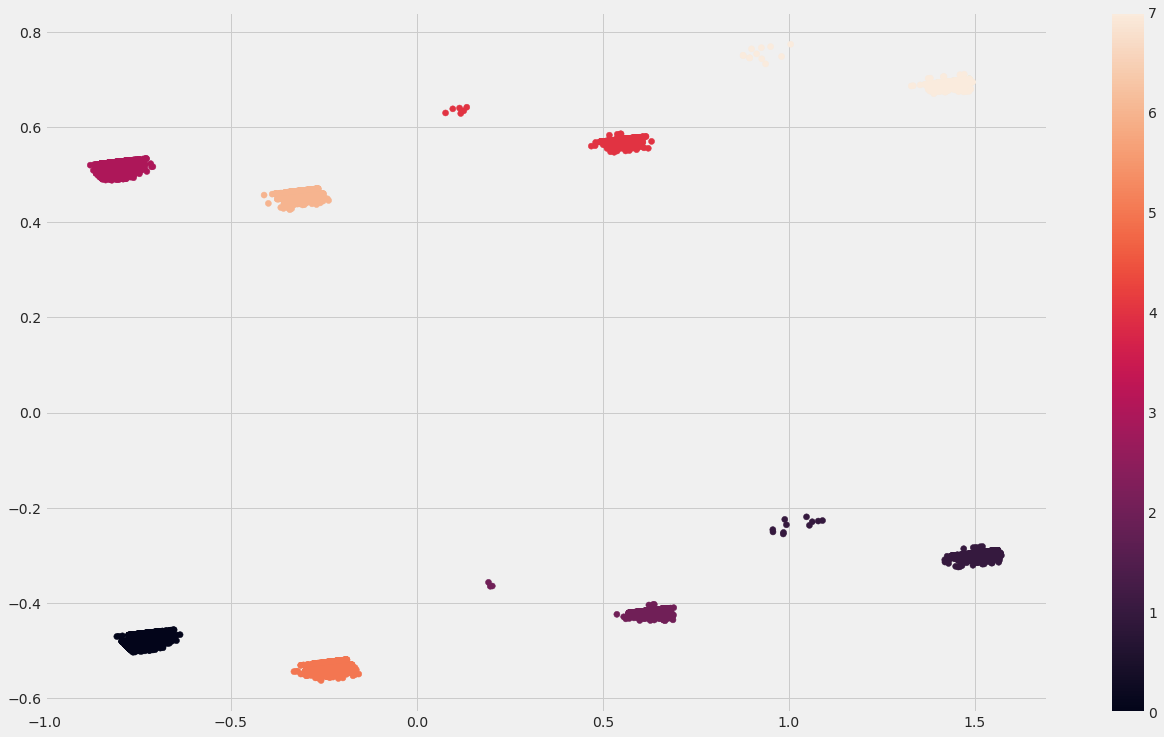

In [302]:
plt.figure(figsize=(20,12))
plt.scatter(data_2D[:,0], data_2D[:,1], c=kmeans.labels_)
plt.colorbar();

#### 3D

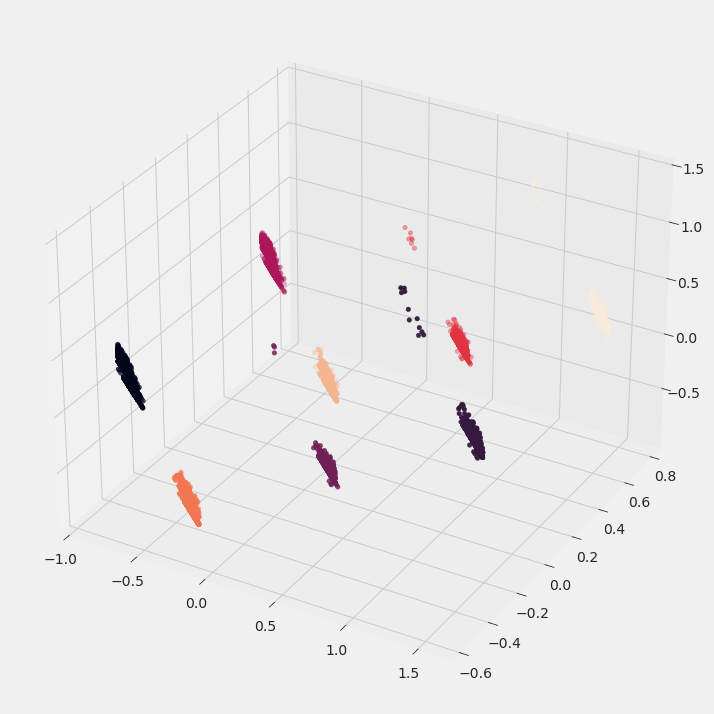

In [303]:
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection = '3d')
scatter = ax.scatter(data_3D[:,0], data_3D[:,1], data_3D[:,2], c=kmeans.labels_)
plt.show()

for the eye this division is much better.

#### test data clusters

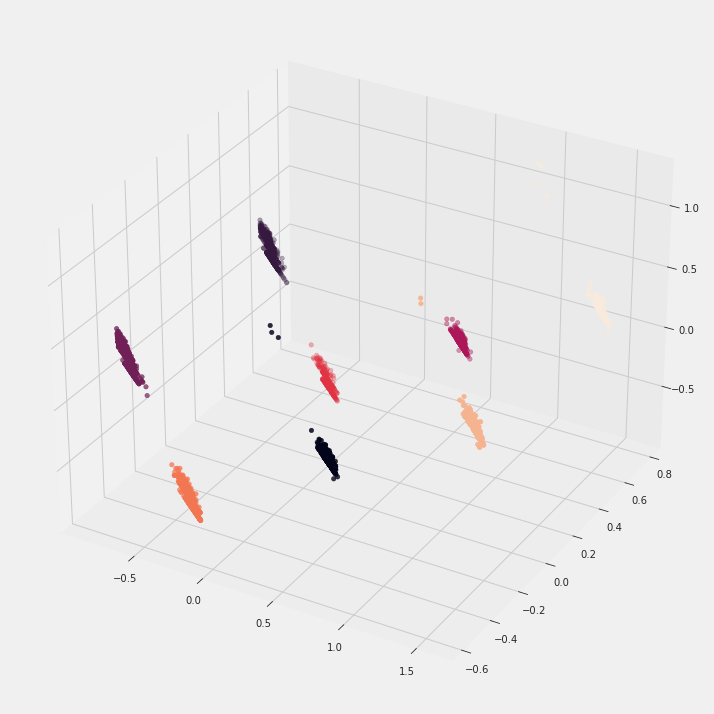

In [412]:
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection = '3d')
scatter = ax.scatter(test_data_3D[:,0], test_data_3D[:,1], test_data_3D[:,2], c=kmeans_test.labels_)
plt.show()

## Cluster analysis

*note - there won't be analysis after every diagram. It will be all-together at the end.

In [305]:
df_saved['Cluster'] = kmeans.labels_
df = df_saved
test_df_saved['Cluster'] = kmeans_test.labels_
test_df = test_df_saved

In [306]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Profession_Type,Experience_Category,Cluster
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,Content_Manager,Low,0
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,Content_Creator,Low,4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,Content_Creator,Low,6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,Content_Manager,Low,1
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,Content_Creator,Low,7


### Feature Distribution in clusters

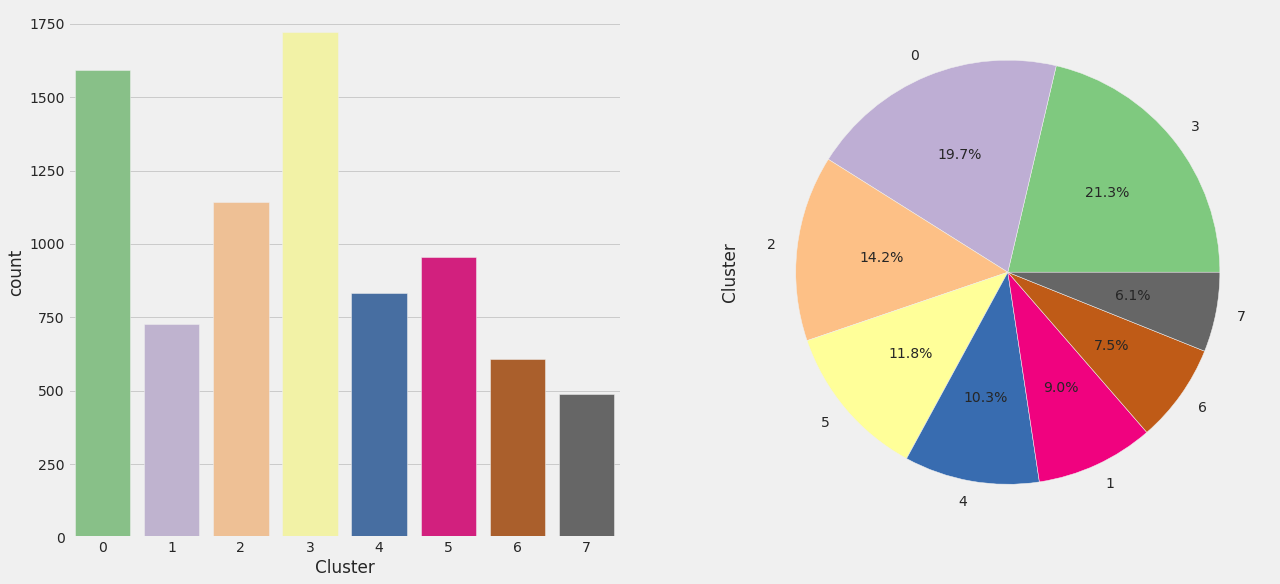

In [307]:
plt.figure(figsize=(30, 20))
plt.subplot(234)
sb.countplot(df['Cluster'],palette="Accent")
plt.subplot(235)
df['Cluster'].value_counts().plot.pie(cmap="Accent",autopct="%1.1f%%");

let's do multivariate analysis on clusters and other variables and see how other variables ar distributed between clusters

### Gender

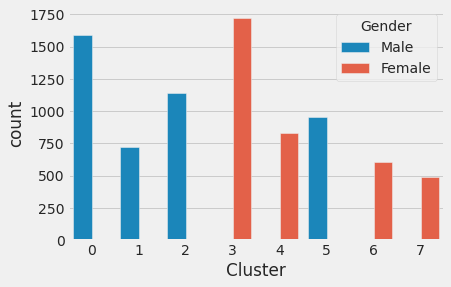

In [308]:
sb.countplot(x='Cluster', hue='Gender', data=df);

### Ever Married

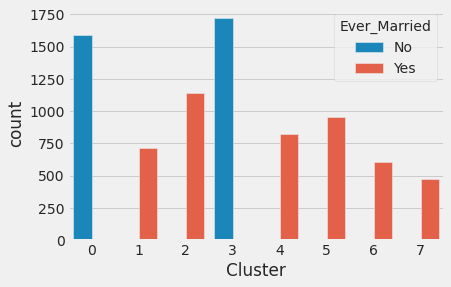

In [309]:
sb.countplot(x='Cluster', hue='Ever_Married', data=df);

### Age

In [310]:
df.groupby(['Cluster'])['Age'].agg([np.mean]).T

Cluster,0,1,2,3,4,5,6,7
mean,30.913945,56.049587,46.55643,33.514236,47.297232,53.242678,49.463054,60.336735


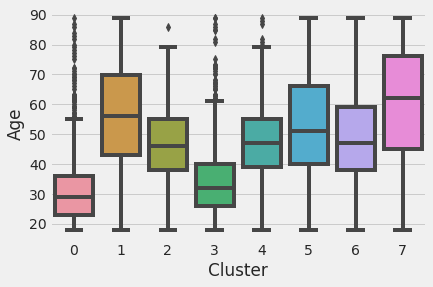

In [311]:
sb.boxplot(x = "Cluster", y = "Age", data = df);

### Graduated

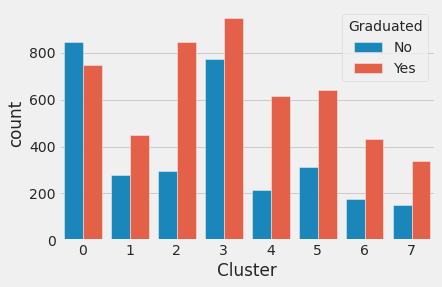

In [312]:
sb.countplot(x='Cluster', hue='Graduated', data=df);

### Profession

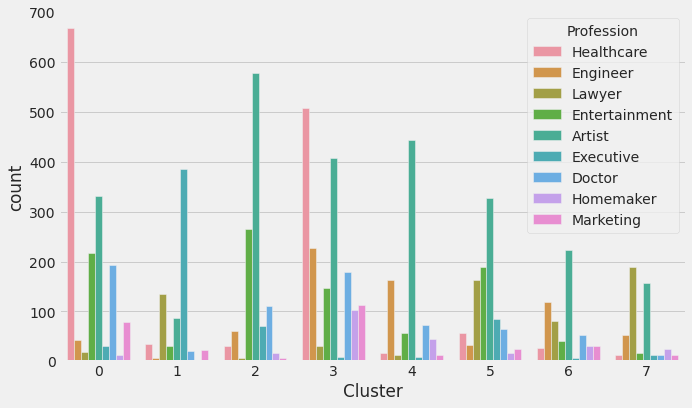

In [313]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Cluster', hue='Profession', data=df);

### Work Experience

In [314]:
df.groupby(['Cluster'])['Work_Experience'].agg([np.mean]).T

Cluster,0,1,2,3,4,5,6,7
mean,2.599874,2.019284,2.245844,3.037769,2.511432,2.093096,2.518883,1.897959


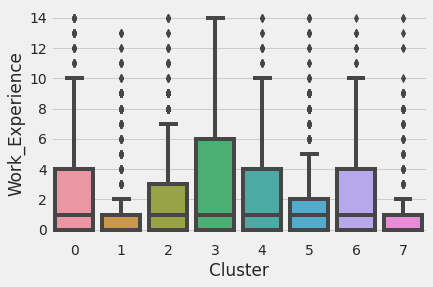

In [315]:
sb.boxplot(x = "Cluster", y = "Work_Experience", data = df);

### Spending Score

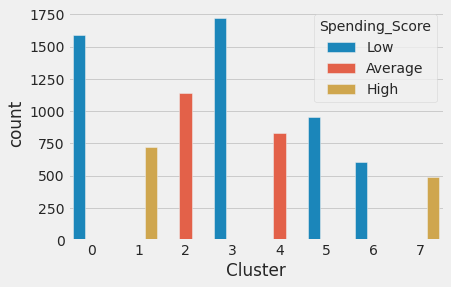

In [316]:
sb.countplot(x='Cluster', hue='Spending_Score', data=df);

### Family Size

In [317]:
df.groupby(['Cluster'])['Family_Size'].agg([np.mean]).T

Cluster,0,1,2,3,4,5,6,7
mean,3.107412,3.103306,3.069116,2.775712,3.113117,2.171548,1.981938,2.765306


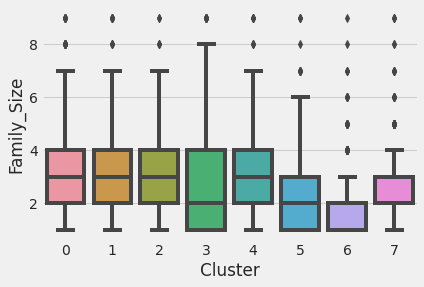

In [318]:
sb.boxplot(x = "Cluster", y = "Family_Size", data = df);

### Var_1

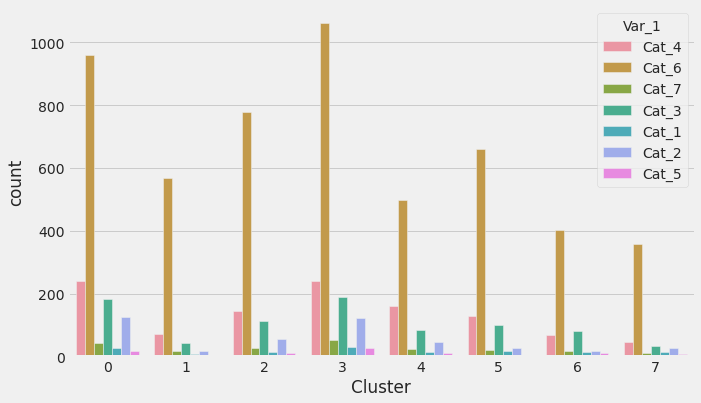

In [319]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Cluster', hue='Var_1', data=df);

### Profession Type

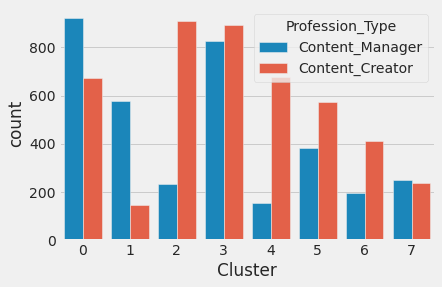

In [320]:
sb.countplot(x='Cluster', hue='Profession_Type', data=df);

### Experience Category

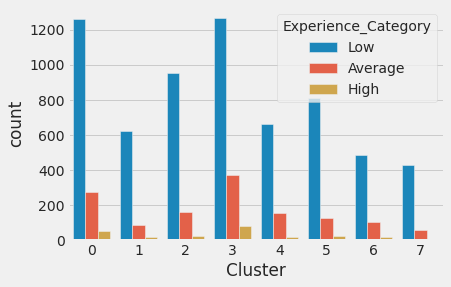

In [321]:
sb.countplot(x='Cluster', hue='Experience_Category', data=df);

## Describing clusters

### Cluster 0

- All-Male
- All-Married
- Age- [38-55] with mean 46
- 74% Graduated
- Spending Score All-Average
- Family Size- [2,4] with mean 3
- Profession Type - 80% Content Creator.

### Cluster 1

- All-Female
- All-Unmarried
- Age- [28-40] with mean 33
- 55% Graduated
- Spending Score All-Low
- Family Size- [0,4] with mean 2.77
- Profession Type - 52% Content Creator.

### Cluster 2

- All-male
- All-Unmarried
- Age- [23-37] with mean 31
- 53% Graduated
- Spending Score All-Low
- Family Size- [2,4] with mean 3
- Profession Type - 42% Content Creator.

### Cluster 3

- All-Female
- All-Married
- Age- [40-55] with mean 47
- 74% Graduated
- Spending Score All-Average
- Family Size- [2,4] with mean 3
- Profession Type - 81% Content Creator.

### Cluster 4

- All-Male
- All-Married
- Age- [41-67] with mean 53
- 67% Graduated
- Spending Score All-Low
- Family Size- [0,3] with mean 2
- Profession Type - 60% Content Creator.

### Cluster 5

- All-Male
- All-Married
- Age- [43-70] with mean 56
- 62% Graduated
- Spending Score All-High
- Family Size- [2,4] with mean 3
- Profession Type - 20% Content Creator.

### Cluster 6

- All-Female
- All-Married
- Age- [39-60] with mean 49
- 71% Graduated
- Spending Score All-Low
- Family Size- [0,2] with mean 2
- Profession Type - 68% Content Creator.

### Cluster 7

- All-Female
- All-Married
- Age- [47-78] with mean 60
- 69% Graduated
- Spending Score All-High
- Family Size- [2,3] with mean 2.8
- Profession Type - 48% Content Creator.

## Naming Clusters

In my Opinion names would go like this:

*class means income/financial state in this case

0) Middle aged, middle class males with family

1) Young, low class single females

2) Young, low class single males

3) Middle aged, middle class females with family

4) Middle Aged, low class males(divorced or no children)

5) Old, high class males with family

6) Middle Aged, low class females(divorced or no children)

7) Old, high class females with family

after knowning all this automobile company can make efficient personalized offers for customers by their clusters.

### Taking look at test data reporting variables

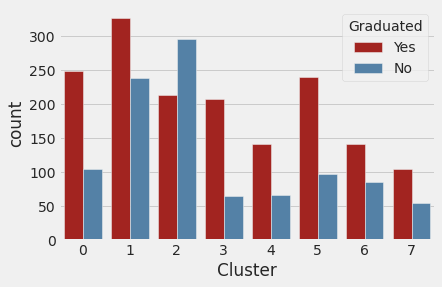

In [322]:
sb.countplot(x='Cluster', hue='Graduated', data=test_df, palette=["#B80F0A",'#4682B4']);

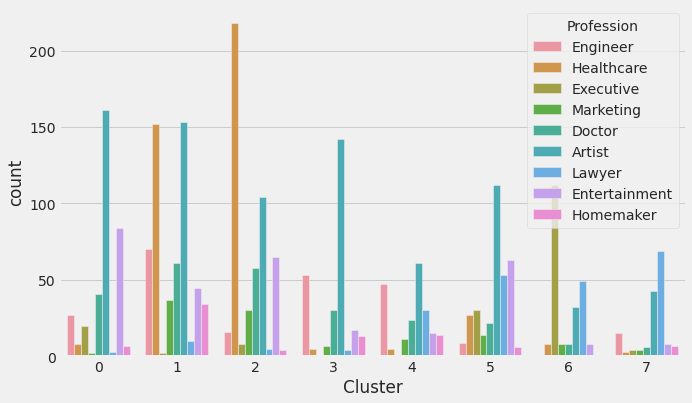

In [323]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Cluster', hue='Profession', data=test_df);

In [324]:
test_df.groupby(['Cluster'])['Work_Experience'].agg([np.mean]).T

Cluster,0,1,2,3,4,5,6,7
mean,2.107649,3.095745,2.470472,2.165441,2.399038,2.065476,1.955947,1.993711


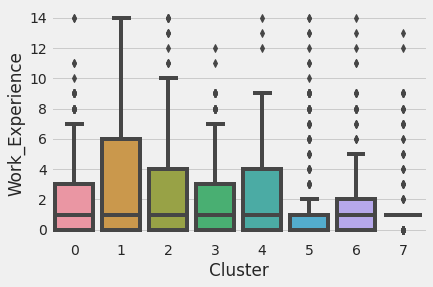

In [325]:
sb.boxplot(x = "Cluster", y = "Work_Experience", data = test_df);

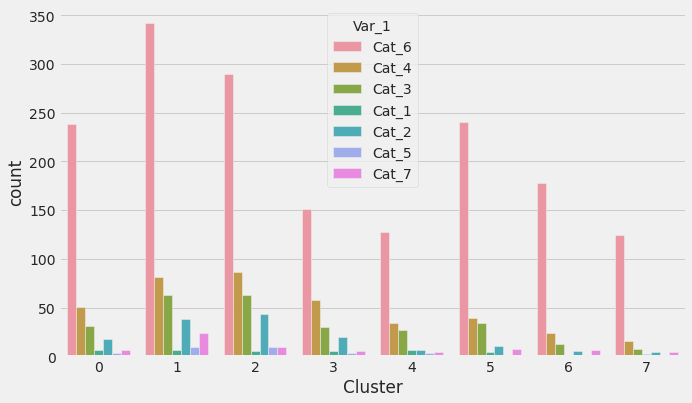

In [326]:
plt.figure(figsize=(10, 6))
sb.countplot(x='Cluster', hue='Var_1', data=test_df);

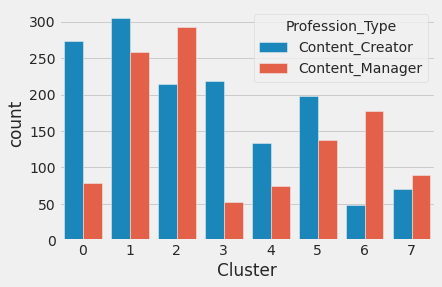

In [327]:
sb.countplot(x='Cluster', hue='Profession_Type', data=test_df);

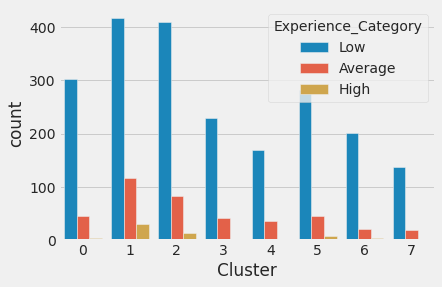

In [328]:
sb.countplot(x='Cluster', hue='Experience_Category', data=test_df);

I'm not quite sure what to make of this. there are some differences between some distributions and some are pretty similar. I guess model isn't Top quality but I think it will do. I spent A LOT of time on this project and there is no time to redo it.

# SOMPY

Let's use one more method for clustering and visual analysis of our data

In [329]:
encoded_df.drop(['Profession'], axis = 1, inplace=True)
encoded_df.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Profession_Type,Experience_Category,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,1,0,3.091042,0,1.0,0,1.386294,1,0,0,0,0,0,0,1,0,0,0
1,0,1,3.637586,1,1.0,1,1.098612,0,0,0,0,1,0,0,0,0,0,0
2,0,1,4.204693,1,1.0,0,0.000000,0,0,0,0,1,0,0,0,0,0,0
3,1,1,4.204693,1,0.0,2,0.693147,1,0,0,0,0,0,0,0,0,1,0
4,0,1,3.688879,1,1.0,2,1.791759,0,0,0,0,0,1,0,0,0,0,0


In [330]:
df = encoded_df
data = df[clustering_vars].values
names = clustering_vars

I'm commenting code below, because I have saved it's output. It took approximately 20 minutes to run this code 100 times, just so you know if you decide to uncomment and run. 

In [331]:
# # removed normalization parameter, because of categorical variables. I have done preprocessing for numericals.
# for i in range(100):
#     sm = SOMFactory().build(data,
#                             mapsize=[random.choice(list(range(6, 10))), random.choice(list(range(4, 6)))],
#                             initialization="random",
#                             component_names=names,
#                             lattice="hexa") 
#     sm.train(n_job=4, verbose=False, train_rough_len=30, train_finetune_len=100)
#     joblib.dump(sm, "model_{}.joblib".format(i))

In [332]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool = glob.glob("./model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)

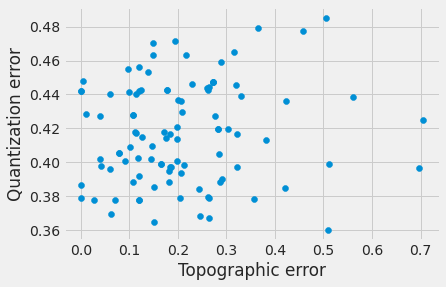

In [333]:
plt.scatter(e_top, e_q)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()

In [395]:
# Manually select the model with better features. In this case, the #10 model has been selected because
# it has lowest topographic error
selected_model = 10
sm = joblib.load(models_pool[selected_model])
topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error = %s\nQuantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.0004957858205255329
Quantization error = 0.3865319081921518


##### let's see distributions of features across clusters

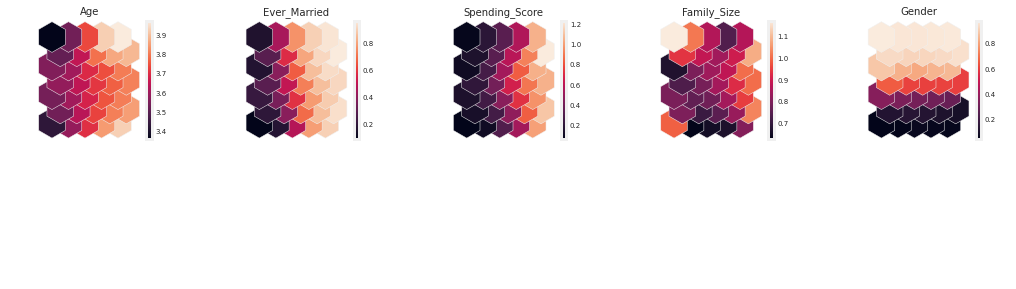

In [391]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"", text_size=7)
view2D.show(sm, col_sz=5, which_dim="all", denormalize=True)
plt.show()

In [2]:
# # Addition of some exogeneous variables to the map
# exogeneous_vars = [c for c in df.columns if not c in clustering_vars+["bmus"]] 
# df["bmus"] = sm.project_data(data)
# df = df[clustering_vars + exogeneous_vars + ["bmus"]]

# empirical_codebook=df.groupby("bmus").mean().values
# matplotlib.rcParams.update({'font.size': 10})
# plot_hex_map(empirical_codebook.reshape(sm.codebook.mapsize + [empirical_codebook.shape[-1]]), 
#              titles=df.columns[:-1], shape=[4, 5], colormap=None)
# plt.show()
##ვერ გავუშვი ეს სამწუხაროდ

##### let's check visualisation of how many members are in each cluster

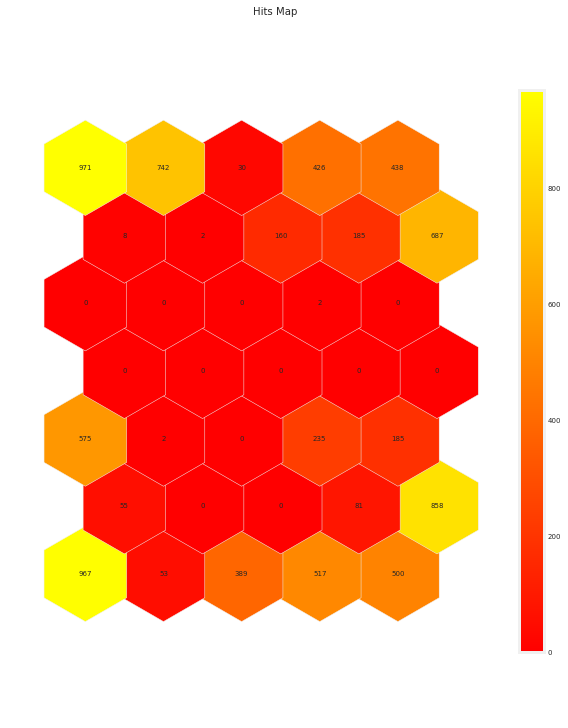

In [393]:
from sompy.visualization.bmuhits import BmuHitsView
#sm.codebook.lattice="rect"
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="autumn", logaritmic=False)
plt.show()

There are zeroes in clusters, because we have very bad data for SOMPY. Data is small and also has many categorical features. But I tried to use it, just for experience.

##### now, let's try to divide our data into 4 clusters

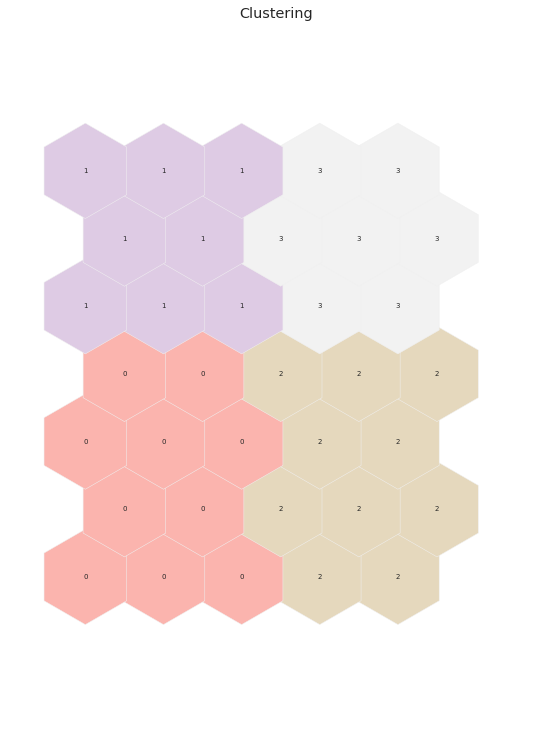

In [405]:
from sompy.visualization.hitmap import HitMapView
sm.cluster(4)

hits  = HitMapView(12, 12,"Clustering",text_size=10, cmap=plt.cm.jet)
a=hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")
plt.show()

# Analyzing clusters

- top right side is old, married males with high spending score.
- top left side is young, unmarried males with low spending score.
- bottom left side is young, unmarried females with low spending score.
- bottom right side is old, married females with high spending score.

but I don't like this clustering, because we don't have separate clusters for middle aged/middle spending score people. So let's try to increase cluster number.

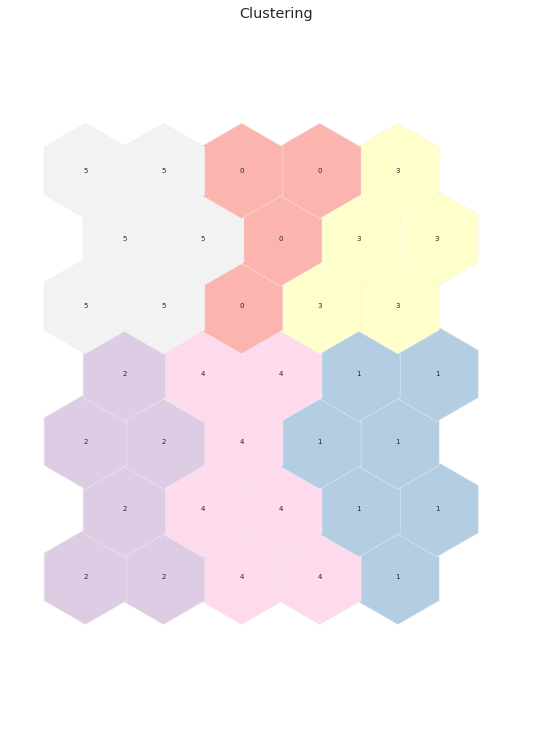

In [406]:
from sompy.visualization.hitmap import HitMapView
sm.cluster(6)

hits  = HitMapView(12, 12,"Clustering",text_size=10, cmap=plt.cm.jet)
a=hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")
plt.show()

Age and spending score increase going left to right, also right side is for married and left side is for unmarried. Top side is for males and bottom side is for females. With this knowledge, we can see that we got pretty nice clusters by dividing into 6.

# ----------------------------------------------THE END----------------------------------------------